# Internal performance comparison of GAlibrate's core genetic algorithm implementations

In this notebook we will do some performance analysis and comparisons of the core genetic algorithms implemented in [GAlibrate](https://github.com/blakeaw/GAlibrate). GAlibrate has three implementations of the core genetic algorithm: Python-only, Numba-accelerated, and Cython-accelerated. We'll compare how each implementation compares when scaling the number of parameters (or dimensionality), population size, and the number of generations. We'll look at each in turn.

To run this notebook we need to have galibrate installed along with both Numba and Cython, as well as pandas, matplotlib. The Python version used for this analysis was 3.7.4.

First we'll do all our imports:

In [1]:
# Non-galibrate imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Notebook magic to inline plots
%matplotlib inline

In [2]:
# galibrate imports
import galibrate
from galibrate import gao
from galibrate.sampled_parameter import SampledParameter
# Manually import each of the run_gao modules -- normally galibrate does this internally
# and automatically assigns the version based whether Numba and/or Cython are installed.
# Python-only
from galibrate import run_gao_py
# Numba accelerated
from galibrate import run_gao_numba
# Cython accelerated -- uses pyximport
import pyximport; pyximport.install(language_level=3)
from galibrate import run_gao_cython

/home/blake/src/python/GAlibrate/galibrate/gao.py:10: RuntimeWarning: ------Running GAO with numba optimization.------
  warnings.warn("------Running GAO with numba optimization.------", RuntimeWarning)


## Model problem and fitness function

For the purposes of this testing we'll use the Egg carton landscape from the [GAlibrate examples](https://github.com/blakeaw/GAlibrate/blob/master/examples/eggcarton/GAO_eggcarton.py). Parmeters will be defined on \[0:10pi\].

Here is the fitness function:

In [3]:
# Define the fitness function (-loglikelihood of eggcarton)
def fitness(theta):
    chi = (np.cos(theta)).prod()
    return (2. + chi)**5

## Scaling with the number of parameters (dimensionality)

We'll start by examining the scaling with the number of parameters while holding the population size and number of generations fixed.

In [4]:
# Define the number of parameters (ndims), population size (popsize), and 
# number of generations (ngenerations)
ndims = list([10, 50, 100, 500, 1000, 5000])
popsize = 100
ngenerations = 50

In [5]:
# Manually set the run_gao version -- Python-only version 
gao.run_gao = run_gao_py
timings = dict()
timings['n_dim'] = list()
timings['avg_time'] = list()
# Loop over the dimensionality (number of parameters)
for ndim in ndims:
    timings['n_dim'].append(ndim)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, popsize, generations=ngenerations)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings['avg_time'].append(ti.average)
timings = pd.DataFrame(timings)
print(timings)

   n_dim  avg_time
0     10  0.046661
1     50  0.094814
2    100  0.162354
3    500  0.668255
4   1000  1.389021
5   5000  7.600903


In [6]:
# Manually set the run_gao version -- Numba version 
gao.run_gao = run_gao_numba
timings_n = dict()
timings_n['n_dim'] = list()
timings_n['avg_time'] = list()
# Loop over the dimensionality (number of parameters)
for ndim in ndims:
    timings_n['n_dim'].append(ndim)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, popsize, generations=ngenerations)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings_n['avg_time'].append(ti.average)
timings_n = pd.DataFrame(timings_n)
print(timings_n)

   n_dim  avg_time
0     10  0.033811
1     50  0.023361
2    100  0.028075
3    500  0.093578
4   1000  0.156955
5   5000  0.805910


In [7]:
# Manually set the run_gao version -- Cython version 
gao.run_gao = run_gao_cython
timings_c = dict()
timings_c['n_dim'] = list()
timings_c['avg_time'] = list()
# Loop over the dimensionality (number of parameters)
for ndim in ndims:
    timings_c['n_dim'].append(ndim)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, popsize, generations=ngenerations)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings_c['avg_time'].append(ti.average)
timings_c = pd.DataFrame(timings_c)
print(timings_c)

   n_dim  avg_time
0     10  0.029318
1     50  0.028422
2    100  0.035196
3    500  0.102143
4   1000  0.185692
5   5000  0.901800


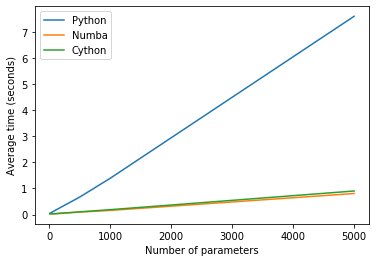

In [8]:
plt.plot(timings['n_dim'].values, timings['avg_time'].values, label='Python')
plt.plot(timings_n['n_dim'].values, timings_n['avg_time'].values, label='Numba')
plt.plot(timings_c['n_dim'].values, timings_c['avg_time'].values, label='Cython')
plt.xlabel("Number of parameters")
plt.ylabel("Average time (seconds)")
plt.legend(loc=0)
plt.show()

The run times appear to roughly scale linearily with number of parameters. It's clear that the Numba and Cython implementations have pretty similar performance, both outperforming the Python-only version. 

Now let's look at the relative performance (speedup factors) of the implementations:

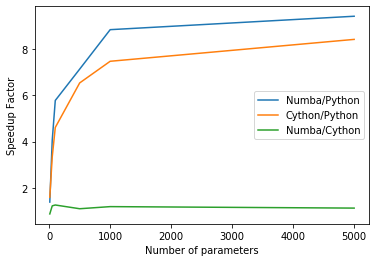

In [9]:
py_o_n = timings['avg_time'].values/timings_n['avg_time'].values
plt.plot(timings['n_dim'].values, py_o_n, label='Numba/Python')
py_o_c = timings['avg_time'].values/timings_c['avg_time'].values
plt.plot(timings_n['n_dim'].values, py_o_c, label='Cython/Python')
c_o_n = timings_c['avg_time'].values/timings_n['avg_time'].values
plt.plot(timings_c['n_dim'].values, c_o_n, label='Numba/Cython')
plt.xlabel("Number of parameters")
plt.ylabel("Speedup Factor")
plt.legend(loc=0)
plt.show()

The speedup factors appear to roughly scale exponentially with the number of parameters. We can see that the Numba version has a little bit of performance advantage over the Cython implementation, but both approach an order of magnitude speedup over the Python-only implementation at the largest number of parameters tested here. 

## Scaling with population size

Now let's examine the scaling with the population size while holding the number of parameters and number of generations fixed.

In [10]:
# Define the number of parameters (ndim), population sizes (popsizes), and 
# number of generations (ngenerations)
ndim = 100
popsizes = list([10, 50, 100, 500, 1000, 5000, 10000, 20000])
ngenerations = 50

In [11]:
# Manually set the run_gao version -- Python-only version 
gao.run_gao = run_gao_py
timings = dict()
timings['pop_size'] = list()
timings['avg_time'] = list()
# Loop over the population sizes
for ps in popsizes:
    timings['pop_size'].append(ps)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, ps, generations=ngenerations)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings['avg_time'].append(ti.average)
timings = pd.DataFrame(timings)
print(timings)
#gao.run_gao

   pop_size   avg_time
0        10   0.022110
1        50   0.096393
2       100   0.184697
3       500   0.885211
4      1000   1.732032
5      5000   9.317504
6     10000  17.987358
7     20000  35.292584


In [12]:
# Manually set the run_gao version -- Numba version 
gao.run_gao = run_gao_numba
timings_n = dict()
timings_n['pop_size'] = list()
timings_n['avg_time'] = list()
# Loop over the population sizes
for ps in popsizes:
    timings_n['pop_size'].append(ps)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, ps, generations=ngenerations)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings_n['avg_time'].append(ti.average)
timings_n = pd.DataFrame(timings_n)
print(timings_n)
#gao.run_gao

   pop_size  avg_time
0        10  0.006087
1        50  0.017009
2       100  0.030592
3       500  0.129576
4      1000  0.257825
5      5000  1.366818
6     10000  2.653046
7     20000  5.507251


In [13]:
# Manually set the run_gao version -- Cython version 
gao.run_gao = run_gao_cython
timings_c = dict()
timings_c['pop_size'] = list()
timings_c['avg_time'] = list()
# Loop over the population sizes
for ps in popsizes:
    timings_c['pop_size'].append(ps)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, ps, generations=ngenerations)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings_c['avg_time'].append(ti.average)
timings_c = pd.DataFrame(timings_c)
print(timings_c)

   pop_size  avg_time
0        10  0.007568
1        50  0.022084
2       100  0.037462
3       500  0.162417
4      1000  0.316073
5      5000  1.624344
6     10000  3.156744
7     20000  6.309421


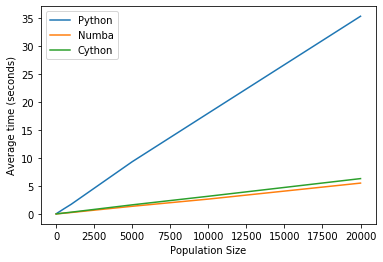

In [14]:
plt.plot(timings['pop_size'].values, timings['avg_time'].values, label='Python')
plt.plot(timings_n['pop_size'].values, timings_n['avg_time'].values, label='Numba')
plt.plot(timings_c['pop_size'].values, timings_c['avg_time'].values, label='Cython')
plt.xlabel("Population Size")
plt.ylabel("Average time (seconds)")
plt.legend(loc=0)
plt.show()

The run times appear to roughly scale linearily with number of parameters. The Numba and Cython implementations have pretty similar performance, both outperforming the Python-only version. 

Now let's look at the relative performance (speedup factors) of the implementations:

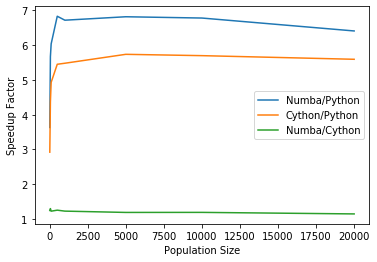

In [15]:
py_o_n = timings['avg_time'].values/timings_n['avg_time'].values
plt.plot(timings['pop_size'].values, py_o_n, label='Numba/Python')
py_o_c = timings['avg_time'].values/timings_c['avg_time'].values
plt.plot(timings_n['pop_size'].values, py_o_c, label='Cython/Python')
c_o_n = timings_c['avg_time'].values/timings_n['avg_time'].values
plt.plot(timings_c['pop_size'].values, c_o_n, label='Numba/Cython')
plt.xlabel("Population Size")
plt.ylabel("Speedup Factor")
plt.legend(loc=0)
plt.show()

The speedup factors appear to roughly scale exponentially with the population size, topping out around 6-7x and 5-6x for the Numba and Cython implementations, respectively. We can see that the Numba version has a little bit of performance advantage over the Cython implementation. 

## Scaling with the number of generations

Finally, let's examine the scaling with the number of generations while holding the number of parameters and population size fixed.

In [16]:
# Define the number of parameters (ndim), population size (popsize), and 
# numbers of generations (ngenerations)
ndim = 100
popsize = 100
ngenerations = list([10, 50, 100, 500])

In [17]:
# Manually set the run_gao version -- Python-only version 
gao.run_gao = run_gao_py
timings = dict()
timings['n_generations'] = list()
timings['avg_time'] = list()
# Loop over the dimensionality (number of parameters)
for ngen in ngenerations:
    timings['n_generations'].append(ngen)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, popsize, generations=ngen)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings['avg_time'].append(ti.average)
timings = pd.DataFrame(timings)
print(timings)

   n_generations  avg_time
0             10  0.040427
1             50  0.171226
2            100  0.328255
3            500  1.695642


In [18]:
# Manually set the run_gao version -- Numba version 
gao.run_gao = run_gao_numba
timings_n = dict()
timings_n['n_generations'] = list()
timings_n['avg_time'] = list()
# Loop over the dimensionality (number of parameters)
for ngen in ngenerations:
    timings_n['n_generations'].append(ngen)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, popsize, generations=ngen)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings_n['avg_time'].append(ti.average)
timings_n = pd.DataFrame(timings_n)
print(timings_n)

   n_generations  avg_time
0             10  0.007827
1             50  0.032107
2            100  0.058829
3            500  0.281847


In [19]:
# Manually set the run_gao version -- Cython version 
gao.run_gao = run_gao_cython
timings_c = dict()
timings_c['n_generations'] = list()
timings_c['avg_time'] = list()
# Loop over the dimensionality (number of parameters)
for ngen in ngenerations:
    timings_c['n_generations'].append(ngen)
    sampled_parameters = [SampledParameter(name=i, loc=0.0, width=10.0*np.pi) for i in range(ndim)]
    go = gao.GAO(sampled_parameters, fitness, popsize, generations=ngen)
    #print(ndim, popsize, gen)
    ti = %timeit -n 3 -r 2 -o -q go.run()
    timings_c['avg_time'].append(ti.average)
timings_c = pd.DataFrame(timings_c)
print(timings_c)

   n_generations  avg_time
0             10  0.008799
1             50  0.038928
2            100  0.074576
3            500  0.350769


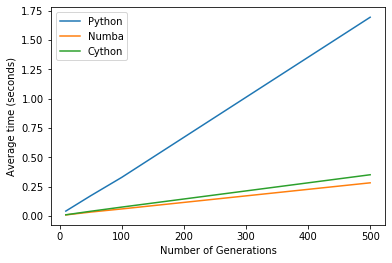

In [20]:
plt.plot(timings['n_generations'].values, timings['avg_time'].values, label='Python')
plt.plot(timings_n['n_generations'].values, timings_n['avg_time'].values, label='Numba')
plt.plot(timings_c['n_generations'].values, timings_c['avg_time'].values, label='Cython')
plt.xlabel("Number of Generations")
plt.ylabel("Average time (seconds)")
plt.legend(loc=0)
plt.show()

The run times appear to roughly scale linearily with number of generations. The Numba and Cython implementations have pretty similar performance, both outperforming the Python-only version. 

Now let's look at the relative performance (speedup factors) of the implementations:

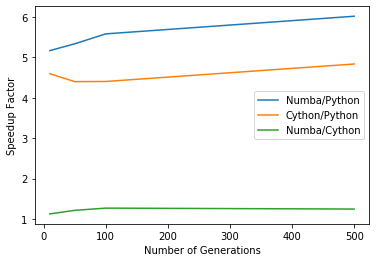

In [21]:
py_o_n = timings['avg_time'].values/timings_n['avg_time'].values
plt.plot(timings['n_generations'].values, py_o_n, label='Numba/Python')
py_o_c = timings['avg_time'].values/timings_c['avg_time'].values
plt.plot(timings_n['n_generations'].values, py_o_c, label='Cython/Python')
c_o_n = timings_c['avg_time'].values/timings_n['avg_time'].values
plt.plot(timings_c['n_generations'].values, c_o_n, label='Numba/Cython')
plt.xlabel("Number of Generations")
plt.ylabel("Speedup Factor")
plt.legend(loc=0)
plt.show()

The speedup factors don't have as strong of dependence on the number of generations, staying around 5-6x and 4-5x for the Numba and Cython implementations, respectively. As in the other cases, we can see that the Numba version has a little bit of a performance advantage over the Cython implementation. And based on the other scaling results, the Numba and Cython implementations would likely offer a larger perfarmace advantage over the Python-only one if the number of parameters or population size were increased.

## Summary

The analysis here shows that the Numba and Cython versions can offer anywhere from about a 2-10 fold speed increase over the Python-only version dependent on the dimensionality of the problem (i.e., the number of parameters) and the choice of GA population size and number of generations (i.e., number of iterations); the benefit tends to increase as the aforementioned quantities increase. the  Additionally, this analysis shows that the Numba implementation offers slightly better performace than the Cython one.

It is worth noting that here we only tested a single model system and fitness function. It would be interesting to test other models and fitness functions as well.